In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob

In [2]:
#load and check data
ds=xr.open_dataset("C:/Users/Megan Jeffers/Documents/EAC_Nuts_Paper/data/EAC_filled-daily-distance-depth-gridded-product_20120401-20220727.nc")
ds

<xarray.Dataset>
Dimensions:    (TIME: 3770, DEPTH: 251, LONGITUDE: 124)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2012-04-01T12:00:00 ... 2022-07-27T12:00:00
  * DEPTH      (DEPTH) float64 0.0 20.0 40.0 60.0 ... 4.96e+03 4.98e+03 5e+03
  * LONGITUDE  (LONGITUDE) float64 153.6 153.6 153.6 153.6 ... 155.3 155.3 155.3
    LATITUDE   (LONGITUDE) float64 ...
Data variables:
    TEMP       (TIME, DEPTH, LONGITUDE) float64 ...
    PSAL       (TIME, DEPTH, LONGITUDE) float64 ...
    UCUR       (TIME, DEPTH, LONGITUDE) float64 ...
    VCUR       (TIME, DEPTH, LONGITUDE) float64 ...
Attributes: (12/38)
    project:                       Integrated Marine Observing System (IMOS),...
    Conventions:                   CF-1.6,IMOS-1.4
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         East Australian Current gridded (depth, di...
    date_created:                  2023-02-15T10:43:02Z
    date_modified:                 2023-02-15T10:43:02Z
    ...                            ...
    citation:                      The citation in a list of references is: "...
    persistent_URL:                https://hdl.handle.net/102.100.100/434305
    acknowledgement:               This project is supported with funding fro...
    disclaimer:                    Data, products and services from CSIRO are...
    license:                       http://creativecommons.org/licenses/by/4.0/
    comment:                       Data from the IMOS North Stradbroke Island...

<Figure size 640x480 with 0 Axes>

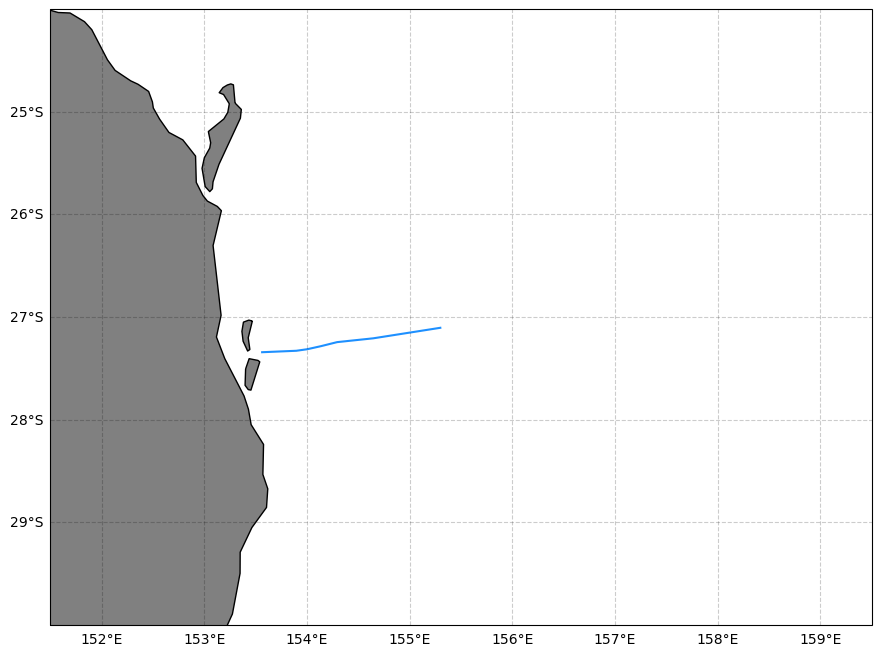

In [4]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])#what is this?
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([151.5, 159.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#ax.plot(df.longitude,df.latitude,linewidth=2, marker='o', transform=ccrs.PlateCarree())
plt.plot(ds.LONGITUDE, ds.LATITUDE,
            color="dodgerblue",
            #s=2,
            #alpha=0.5,
            transform=ccrs.PlateCarree()) ## Important
#axis and labels
gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True

In [17]:
#volume trasnport calculate (me code)

# Extract velocity components 
v_velocity = ds.isel(TIME=slice(0,301))['VCUR']
u_velocity = ds.isel(TIME=slice(0,301))['UCUR']


#get coordinates
lon = ds.isel(TIME=slice(0,301))['LONGITUDE']
lat = ds.isel(TIME=slice(0,301))['LATITUDE']

# Define the depth coordinates
#depth = ds['DEPTH'].isel(DEPTH=slice(0,101)) #0-2000m
depth2000=ds.isel(TIME=slice(0,301))['DEPTH'].sel(DEPTH=slice(0,2000))
depthfull=ds.isel(TIME=slice(0,301))['DEPTH']

#daves tips to do the integral
#  int(v)dxdz = sum(sum(v*dx*dz))
# dx = dist(Lon/Lat_0 - Lon/Lat_1) metres
# dz = ds.Depth.diff() [might find that length is -1 - so need to add 0 to top etc]
# sum(sum(transport*dx*dz))


#approximate lengths
dxdy=111139*np.sqrt((lon.diff(dim='LONGITUDE')**2+lat.diff(dim='LONGITUDE')**2))
dz2000=depth2000.diff(dim='DEPTH')
dzfull=depthfull.diff(dim='DEPTH')
area2000=dxdy*dz2000
areafull=dxdy*dzfull

transport2000=(v_velocity*area2000).sum(dim='LONGITUDE').sum(dim='DEPTH')
transportfull=(v_velocity*areafull).sum(dim='LONGITUDE').sum(dim='DEPTH')

[Text(0.5, 1.0, 'Net Volume Transport'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Transport (x10^6 m3 S-1)')]

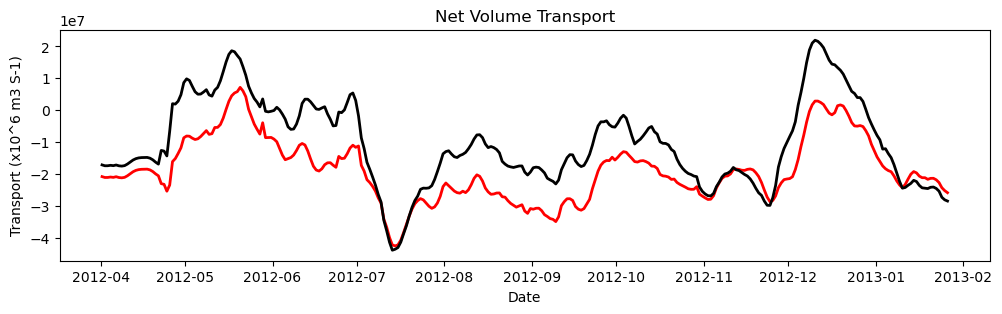

In [18]:
fig, ax=plt.subplots(figsize=(12, 3))

ax.plot(transport2000.TIME, transport2000.values,linewidth=2,color='red')
ax.plot(transportfull.TIME, transportfull.values,linewidth=2,color='black')
ax.set(title = "Net Volume Transport",
       xlabel = "Date",
       ylabel = "Transport (x10^6 m3 S-1)")

In [20]:
#heat transport

# Extract variables
temperature = ds.isel(TIME=slice(0,301))['TEMP'] 

# Extract velocity components 
v_velocity = ds.isel(TIME=slice(0,301))['VCUR']
u_velocity = ds.isel(TIME=slice(0,301))['UCUR']


#get coordinates
lon = ds.isel(TIME=slice(0,301))['LONGITUDE']
lat = ds.isel(TIME=slice(0,301))['LATITUDE']

# Define the depth coordinates
#depth = ds['DEPTH'].isel(DEPTH=slice(0,101)) #0-2000m
depth2000=ds.isel(TIME=slice(0,301))['DEPTH'].sel(DEPTH=slice(0,2000))
depthfull=ds.isel(TIME=slice(0,301))['DEPTH']

# Define constants
density = 1025.0  # Example value for seawater density in kg/m³
specific_heat_capacity = 3850.0  # Example value for specific heat capacity in J/(kg·K)


#calculate grid spacing and area
dxdy=111139*np.sqrt((lon.diff(dim='LONGITUDE')**2+lat.diff(dim='LONGITUDE')**2))
dz2000=depth2000.diff(dim='DEPTH')
dzfull=depthfull.diff(dim='DEPTH')
area2000=dxdy*dz2000
areafull=dxdy*dzfull

#calculate flux
heat_transport2000=(density*specific_heat_capacity*temperature *v_velocity*area2000).sum(dim='LONGITUDE').sum(dim='DEPTH')
heat_PW2000=heat_transport2000/1e15

heat_transportfull=(density*specific_heat_capacity*temperature *v_velocity*areafull).sum(dim='LONGITUDE').sum(dim='DEPTH')
heat_PWfull=heat_transport2000/1e15


[Text(0.5, 1.0, 'Heat Transport above 2000m'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Heat Flux (PW)')]

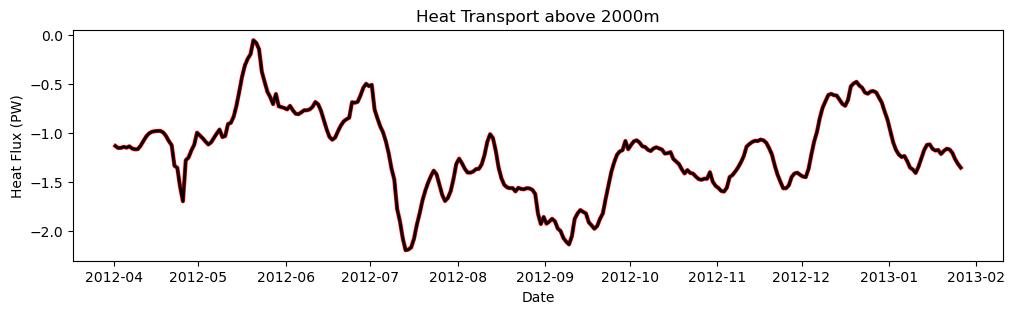

In [22]:
fig, ax=plt.subplots(figsize=(12, 3))

ax.plot(heat_PW2000.TIME, heat_PW2000.values,linewidth=3,color='red')
ax.plot(heat_PWfull.TIME, heat_PWfull.values,linewidth=2,color='black')
ax.set(title = "Heat Transport",
       xlabel = "Date",
       ylabel = "Heat Flux (PW)")


Repeat same steps but this time different way to calculate dx

In [19]:
#Define constants
density = 1025.0  # Example value for seawater density in kg/m³
specific_heat_capacity = 3850.0  # Example value for specific heat capacity in J/(kg·K)

#different distance method
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))*1000
lon = ds.isel(TIME=slice(0,301))['LONGITUDE']
lat = ds.isel(TIME=slice(0,301))['LATITUDE']


dx= []
for n in range(0,(len(lon)-1),1):
    dx.append(distance(lat[n],lon[n],lat[n+1],lon[n+1]))   
#distance(lat[0],lon[0],lat[1],lon[1])
dx.append(0)
dx=xr.DataArray(dx,dims='LONGITUDE')

# Extract velocity components 
v_velocity = ds.isel(TIME=slice(0,301))['VCUR']
u_velocity = ds.isel(TIME=slice(0,301))['UCUR']

# Extract variables
temperature = ds.isel(TIME=slice(0,301))['TEMP'] 



#get coordinates
lon = ds.isel(TIME=slice(0,301))['LONGITUDE']
lat = ds.isel(TIME=slice(0,301))['LATITUDE']

# Define the depth coordinates
#depth = ds['DEPTH'].isel(DEPTH=slice(0,101)) #0-2000m
depth2000=ds.isel(TIME=slice(0,301))['DEPTH'].sel(DEPTH=slice(0,2000))
depthfull=ds.isel(TIME=slice(0,301))['DEPTH']

#daves tips to do the integral
#  int(v)dxdz = sum(sum(v*dx*dz))
# dx = dist(Lon/Lat_0 - Lon/Lat_1) metres
# dz = ds.Depth.diff() [might find that length is -1 - so need to add 0 to top etc]
# sum(sum(transport*dx*dz))

dz2000=depth2000.diff(dim='DEPTH')
dzfull=depthfull.diff(dim='DEPTH')
area2000=dx*dz2000
areafull=dx*dzfull

transport2000=(v_velocity*area2000).sum(dim='LONGITUDE').sum(dim='DEPTH')
transportfull=(v_velocity*areafull).sum(dim='LONGITUDE').sum(dim='DEPTH')

#calculate flux
heat_transport2000=(density*specific_heat_capacity*temperature *v_velocity*area2000).sum(dim='LONGITUDE').sum(dim='DEPTH')
heat_PW2000=heat_transport2000/1e15

heat_transportfull=(density*specific_heat_capacity*temperature *v_velocity*areafull).sum(dim='LONGITUDE').sum(dim='DEPTH')
heat_PWfull=heat_transport2000/1e15


[Text(0.5, 1.0, 'Net Volume Transport'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Transport (x10^6 m3 S-1)')]

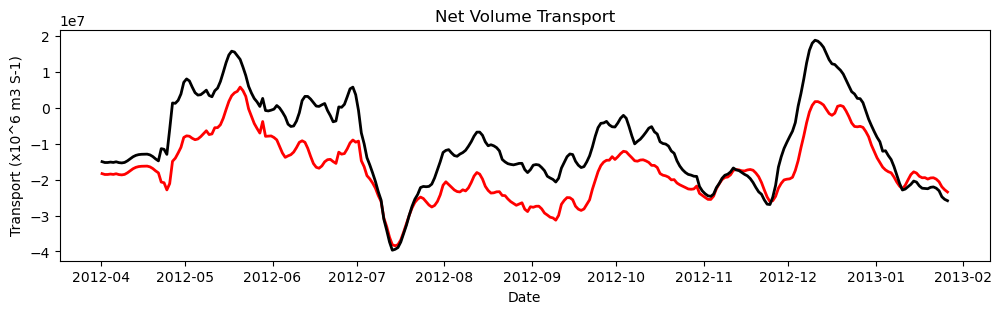

In [16]:
fig, ax=plt.subplots(figsize=(12, 3))

ax.plot(transport2000.TIME, transport2000.values,linewidth=2,color='red')
ax.plot(transportfull.TIME, transportfull.values,linewidth=2,color='black')
ax.set(title = "Net Volume Transport",
       xlabel = "Date",
       ylabel = "Transport (x10^6 m3 S-1)")

[Text(0.5, 1.0, 'Heat Transport'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Heat Flux (PW)')]

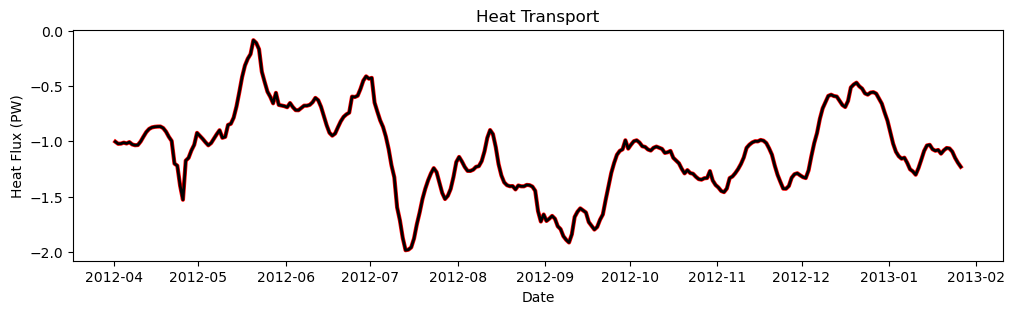

In [20]:
fig, ax=plt.subplots(figsize=(12, 3))

ax.plot(heat_PW2000.TIME, heat_PW2000.values,linewidth=3,color='red')
ax.plot(heat_PWfull.TIME, heat_PWfull.values,linewidth=2,color='black')
ax.set(title = "Heat Transport",
       xlabel = "Date",
       ylabel = "Heat Flux (PW)")